In [2]:
import os
import numpy as np
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 

In [64]:
max_temp = pd.read_csv('Maximum.csv')
min_temp = pd.read_csv('Minimum.csv')

In [19]:
max_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Mean maximum temperature (°C),Quality
0,IDCJAC0002,86282,1970,7,13.1,Y
1,IDCJAC0002,86282,1970,8,13.4,Y
2,IDCJAC0002,86282,1970,9,14.6,Y
3,IDCJAC0002,86282,1970,10,18.8,Y
4,IDCJAC0002,86282,1970,11,21.7,Y


In [20]:
min_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Mean minimum temperature (°C),Quality
0,IDCJAC0004,86282,1970,7,5.2,Y
1,IDCJAC0004,86282,1970,8,5.1,Y
2,IDCJAC0004,86282,1970,9,4.9,Y
3,IDCJAC0004,86282,1970,10,7.2,Y
4,IDCJAC0004,86282,1970,11,9.6,Y


## Data Validation 

In [21]:
# Checking for missing data 
max_temp.isnull().value_counts(), min_temp.isnull().value_counts()

(Product code  Bureau of Meteorology station number  Year   Month  Mean maximum temperature (°C)  Quality
 False         False                                 False  False  False                          False      653
 Name: count, dtype: int64,
 Product code  Bureau of Meteorology station number  Year   Month  Mean minimum temperature (°C)  Quality
 False         False                                 False  False  False                          False      653
 Name: count, dtype: int64)

## Data Cleaning 

In [65]:
# Data is clean -- further cleaning required if not

drop_cols = [0,1]
max_temp.drop(max_temp.columns[drop_cols], axis=1, inplace=True)
min_temp.drop(min_temp.columns[drop_cols], axis=1, inplace=True)
max_temp.rename(columns={'Mean maximum temperature (°C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Mean minimum temperature (°C)':'Tmin'}, inplace=True)

In [32]:
max_temp.head()

,Year,Month,Tmax,Quality
0,1970,7,13.1,Y
1,1970,8,13.4,Y
2,1970,9,14.6,Y
3,1970,10,18.8,Y
4,1970,11,21.7,Y


In [33]:
min_temp.head()

,Year,Month,Tmin,Quality
0,1970,7,5.2,Y
1,1970,8,5.1,Y
2,1970,9,4.9,Y
3,1970,10,7.2,Y
4,1970,11,9.6,Y


In [66]:
max_temp_cleaned = max_temp.drop(columns=['Quality'])
min_temp_cleaned = min_temp.drop(columns=['Quality'])

temps = pd.merge(max_temp_cleaned, min_temp_cleaned, on=['Year', 'Month'])

def avg_temp(row):
    return (row.Tmax + row.Tmin)/2

temps['T'] = temps.apply(avg_temp, axis=1)
temps.head()

,Year,Month,Tmax,Tmin,T
0,1970,7,13.1,5.2,9.15
1,1970,8,13.4,5.1,9.25
2,1970,9,14.6,4.9,9.75
3,1970,10,18.8,7.2,13.00
4,1970,11,21.7,9.6,15.65


In [67]:
temps.describe()

,Year,Month,Tmax,Tmin,T
count,653.000000,653.000000,653.000000,653.000000,653.000000
mean,1997.206738,6.519142,19.913629,9.583002,14.748315
std,15.723312,3.450574,4.922994,3.155121,3.998240
min,1970.000000,1.000000,11.700000,3.100000,7.800000
25%,1984.000000,4.000000,15.400000,6.800000,11.150000
50%,1997.000000,7.000000,19.900000,9.200000,14.450000
75%,2011.000000,10.000000,24.300000,12.200000,18.300000
max,2024.000000,12.000000,30.400000,16.800000,23.550000


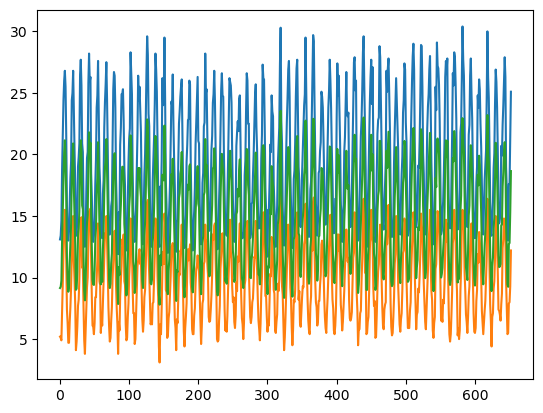

In [68]:
plt.plot(figsize=(8,6))
plt.plot(temps['Tmax'])
plt.plot(temps['Tmin'])
plt.plot(temps['T'])
plt.show()

## Temperature distribution

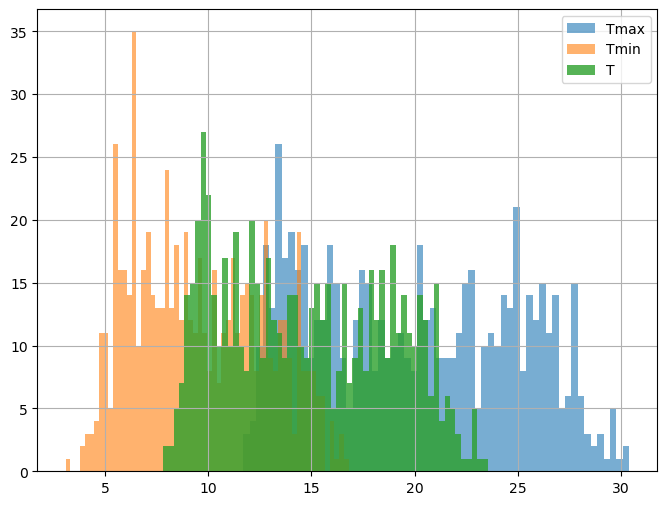

In [69]:
plt.figure(figsize=(8,6))
temps.Tmax.hist(bins=60, alpha=0.6, label='Tmax')
temps.Tmin.hist(bins=60, alpha=0.6, label='Tmin')
temps['T'].hist(bins=60, alpha=0.8, label='T')
plt.legend()
plt.show()

In [76]:
temps_season = temps.copy(deep=True)
mask = (temps_season['Month']>=6) & (temps_season['Month']<=12)
temps_season['summer'] = np.where(mask,1,0)
temps_season['winter'] = np.where(temps_season['summer'] != 1,1,0)
temps_season

,Year,Month,Tmax,Tmin,T,summer,winter
0,1970,7,13.1,5.2,9.15,1,0
1,1970,8,13.4,5.1,9.25,1,0
2,1970,9,14.6,4.9,9.75,1,0
3,1970,10,18.8,7.2,13.00,1,0
4,1970,11,21.7,9.6,15.65,1,0
...,...,...,...,...,...,...,...
648,2024,7,13.0,5.5,9.25,1,0
649,2024,8,17.6,7.9,12.75,1,0
650,2024,9,17.6,8.0,12.80,1,0
651,2024,10,21.3,9.3,15.30,1,0


## Bimodal Distribution

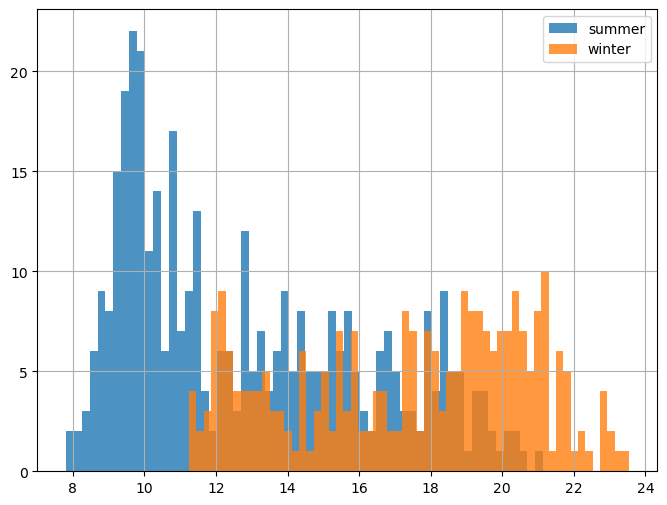

In [77]:
plt.figure(figsize=(8,6))
temps_season[temps_season['summer'] == 1]['T'].hist(bins=60, alpha=0.8, label='summer')
temps_season[temps_season['winter'] == 1]['T'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

## Time-series Decomposition 

Additive model: $$y_{t} = T_{t} + S_{t} + e_{t}$$

Decomposition components: 
1. Computing trend cycle $\hat{T}_{t}$ using a moving average
2. Calculating de-trended series $y_{t} - \hat{T}_{t}$
3. Estimating seasonal components $\hat{S}_{t}$ by averaging detrended values for a well-defined season (even time-steps), such that $\sum_{t} \hat{S}_{t} = 0$
4. Calculating the remainder $e_{t} = y_{t} - \hat{T}_{t} + \hat{S}_{t}$

In [78]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

python(91348) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [79]:
temps.sort_index(inplace=True)
temps

,Year,Month,Tmax,Tmin,T
0,1970,7,13.1,5.2,9.15
1,1970,8,13.4,5.1,9.25
2,1970,9,14.6,4.9,9.75
3,1970,10,18.8,7.2,13.00
4,1970,11,21.7,9.6,15.65
...,...,...,...,...,...
648,2024,7,13.0,5.5,9.25
649,2024,8,17.6,7.9,12.75
650,2024,9,17.6,8.0,12.80
651,2024,10,21.3,9.3,15.30


### Trends breakdown

<Axes: title={'center': 'Rolling mean over annual periods'}>

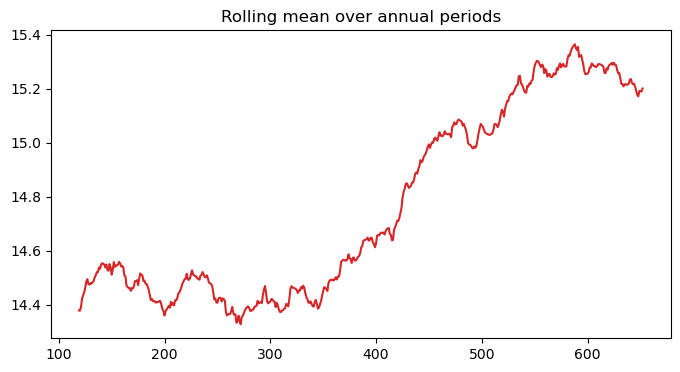

In [83]:
temps['T'].rolling(window = 12*10).mean().plot(figsize=(8,4), color='tab:red', title='Rolling mean over annual periods')

<Axes: title={'center': 'Rolling variance over annual periods'}>

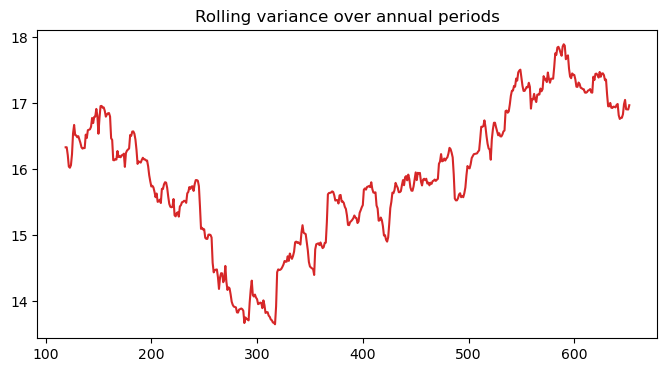

In [82]:
temps['T'].rolling(window = 12*10).var().plot(figsize=(8,4), color='tab:red', title='Rolling variance over annual periods')

### Seasonal Decomposition  

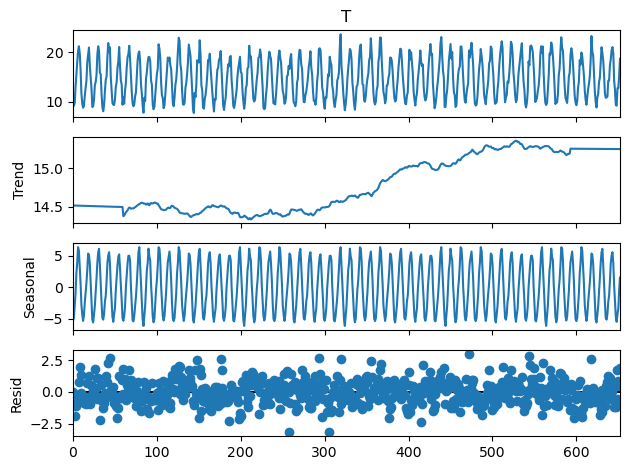

In [86]:
decompose_results = seasonal_decompose(temps['T'], model='additive', period=int(12*10), extrapolate_trend='freq')

trend = decompose_results.trend
seasonal = decompose_results.seasonal
residual = decompose_results.resid

decompose_results.plot()
plt.show()

### Visualization of 10 Years Data

(-15.0, 15.0)

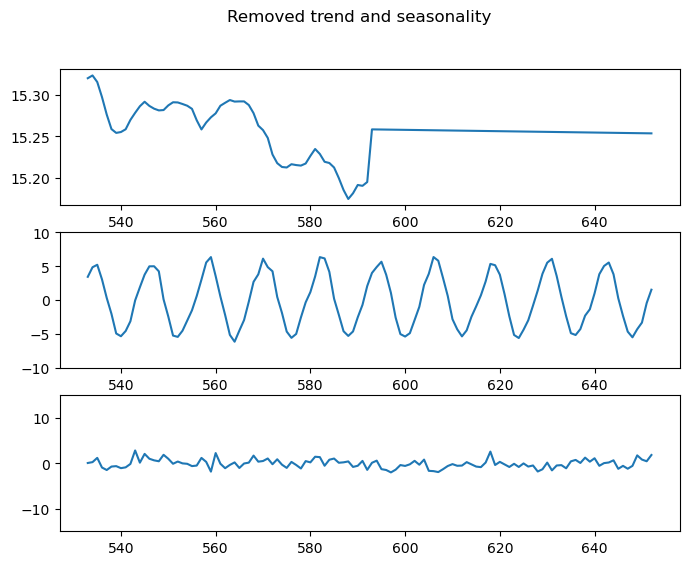

In [88]:
yrs_examine = 12*10
fig, axs = plt.subplots(3, figsize=(8,6))
fig.suptitle('Removed trend and seasonality')
axs[0].plot(trend[-yrs_examine:])
axs[1].plot(seasonal[-yrs_examine:])
axs[1].set_ylim([-10,10])
axs[2].plot(residual[-yrs_examine:])
axs[2].set_ylim([-15,15])

### Residual Distribution

<Axes: >

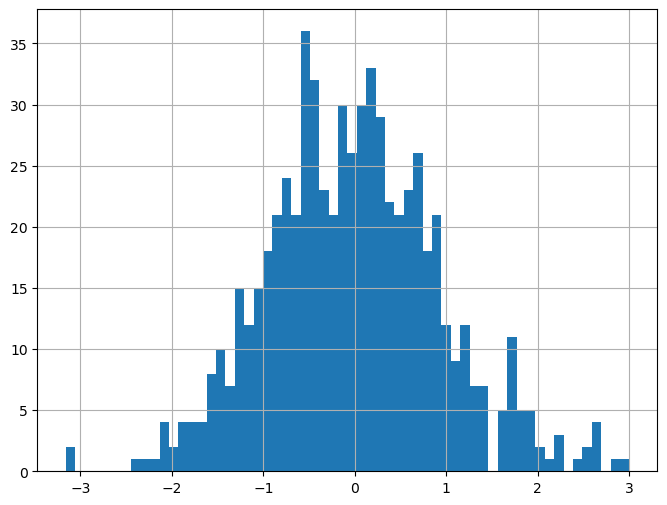

In [89]:
residual.hist(bins=60, figsize=(8,6))

## Testing for Stationarity of Time-Series with Dicky-Fuller 

#### Stationary process: 

$$ F_{X}(x_{t_{1}+\tau}, ..., x_{t_{n}+\tau}) = F_{X}(x_{t_{1}}, ..., x_{t_{n}}) \;\forall \tau, t_{1}, ..., t_{n} \in \mathbb{R}, \forall n > 0 \in\mathbb{N} $$

Dicky-Fuller Test is a unit root test. If p-value is close to 1, there likely is a unit root. If p-value is close to 0, there likely isn't one and the time-series is stationary.

In [90]:
dftest = adfuller(residual, autolag='AIC')

print("1. ADF: ",dftest[0])
print("2. p-value: ",dftest[1])
print("3. Num of lags: ",dftest[2])
print("4. Num of observations: ",dftest[3])
print("5. Critical values: ")
for key, val in dftest[4].items():
    print("\t",key,": ",val)

1. ADF:  -11.408706352140516
2. p-value:  7.340350157577175e-21
3. Num of lags:  2
4. Num of observations:  650
5. Critical values: 
	 1% :  -3.4404504809576695
	 5% :  -2.8659967824852073
	 10% :  -2.569143417751479


## Analysis of Serial Correlations

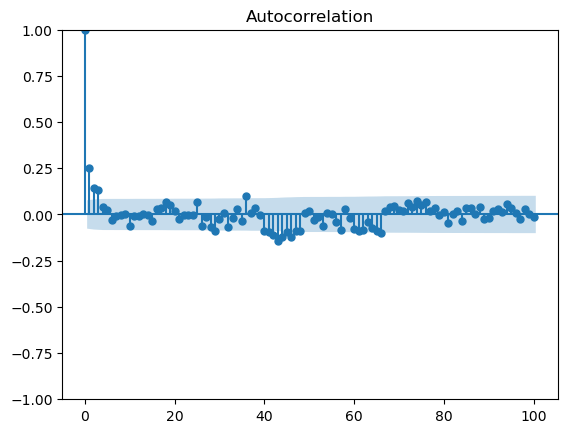

In [91]:
plot_acf(residual, lags=100)
plt.show()

### Autocorrelation Functions (ACF) and Partial Autocorrelation Functions (PACF)

ACF: $$\rho_{k,k} = \mathbb{E}[Z_{t}, Z_{\hat{t}}]$$

PACF: $$\phi_{k,k} = \mathbb{E} [Z_{t}, Z_{t \pm k}]$$

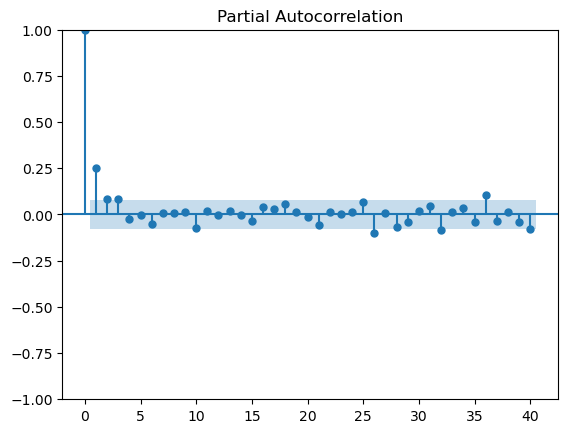

In [92]:
plot_pacf(residual, lags=40)
plt.show()

### Akaike Information Criterion (AIC)

$$AIC = -2\ln(L) + 2k$$

In [99]:
residuals = residual.copy(deep=True)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:2108: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  full_mod = AutoReg(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:2185: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  mod = AutoReg(


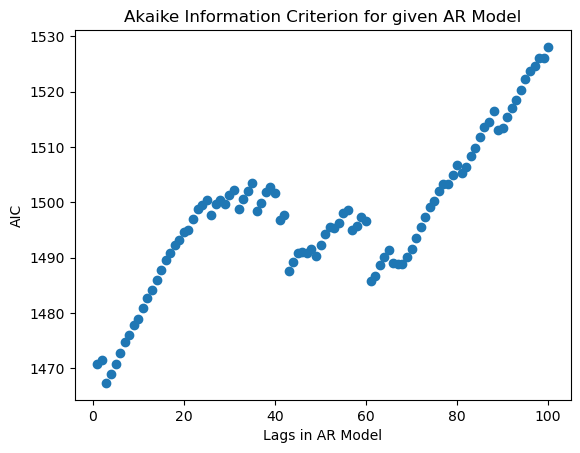

In [102]:
mod = ar_select_order(residuals, maxlag=100, ic='aic', old_names=True)

aic = []
for key, val in mod.aic.items():
    if key != 0:
        aic.append((key[-1], val))
        
aic.sort()
x,y = [x for x, y in aic], [y for x, y in aic]

plt.scatter(x,y)
# plt.plot([0,40], [y[15],y[15]], 'tab:orange')
# plt.text(3, y[15]+0.002, '{0}'.format(round(y[15],3)), color='tab:orange')
# plt.plot([0,40], [y[20],y[20]], 'k--')
# plt.text(3, y[20]-0.004, '{0}'.format(round(y[20],3)))
plt.title('Akaike Information Criterion for given AR Model')
plt.xlabel('Lags in AR Model')
plt.ylabel('AIC')
plt.show()

### Fitting an AR, which minimizes at lags = 1

In [105]:
model = AutoReg(residuals, lags = 40, old_names=True)
model_fit = model.fit()
coef = model_fit.params
res = model_fit.resid
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                  653
Model:                    AutoReg(40)   Log Likelihood                -783.345
Method:               Conditional MLE   S.D. of innovations              0.868
Date:                Tue, 17 Dec 2024   AIC                           1650.689
Time:                        12:47:59   BIC                           1836.260
Sample:                            40   HQIC                          1722.859
                                  653                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0087      0.035     -0.246      0.806      -0.078       0.060
resid.L1       0.2392      0.040      5.948      0.000       0.160       0.318
resid.L2       0.0647      0.041      1.565      0.1

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_85230/2588294734.py:1: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(residuals, lags = 40, old_names=True)


/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_85230/3356241582.py:1: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(residuals, lags = 1, old_names=True)


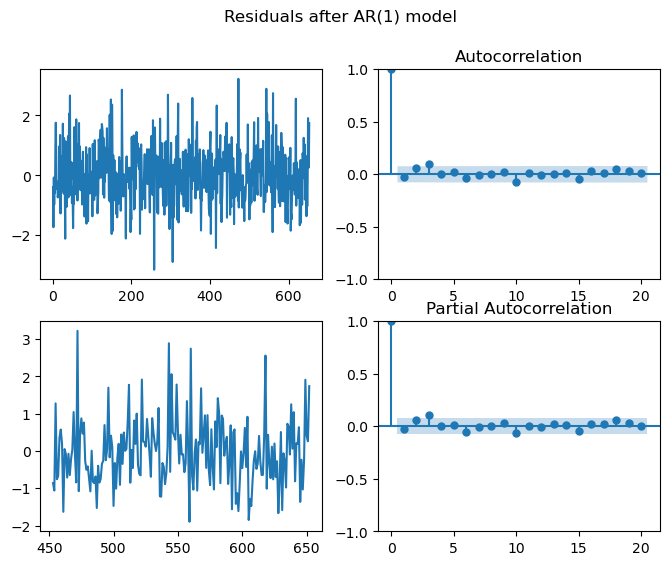

In [107]:
model = AutoReg(residuals, lags = 1, old_names=True)
model_fit = model.fit()
coef = model_fit.params
res = model_fit.resid


fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Residuals after AR(1) model')
axs[0,0].plot(res)
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1])
plt.show()

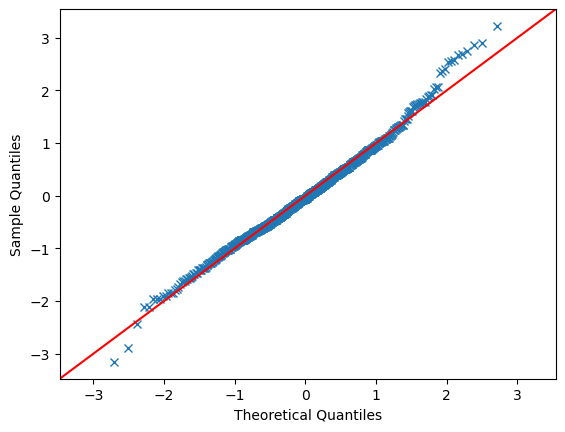

In [109]:
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

qqplot(res, marker='x', dist=norm, loc=0, scale=np.std(res), line='45')
plt.show()